## LTFS Data Science FinHack 2

LTFS receives a lot of requests for its various finance offerings that include housing loan, two-wheeler loan, real estate financing and micro loans. The number of applications received is something that varies a lot with season. Going through these applications is a manual process and is tedious. Accurately forecasting the number of cases received can help with resource and manpower management resulting into quick response on applications and more efficient processing.

## Problem Statement

You have been appointed with the task of forecasting daily cases for next 3 months for 2 different business segments aggregated at the country level keeping in consideration the following major Indian festivals (inclusive but not exhaustive list): Diwali, Dussehra, Ganesh Chaturthi, Navratri, Holi etc. (You are free to use any publicly available open source external datasets). Some other examples could be:

Weather Macroeconomic variables Note that the external dataset must belong to a reliable source.

Data Dictionary The train data has been provided in the following way:

For business segment 1, historical data has been made available at branch ID level For business segment 2, historical data has been made available at State level.
Train File Variable Definition application_date Date of application segment Business Segment (1/2) branch_id Anonymised id for branch at which application was received state State in which application was received (Karnataka, MP etc.) zone Zone of state in which application was received (Central, East etc.) case_count (Target) Number of cases/applications received

Test File Forecasting needs to be done at country level for the dates provided in test set for each segment.

Variable Definition id Unique id for each sample in test set application_date Date of application segment Business Segment (1/2)

Evaluation
Evaluation Metric The evaluation metric for scoring the forecasts is *MAPE (Mean Absolute Percentage Error) M with the formula:

Where At is the actual value and Ft is the forecast value.

The Final score is calculated using MAPE for both the segments using the formula:

Important Notes
Note that feasibility of implementation of top solutions will be considered while adjudging winners The solution must produce satisfactory results for both the business segments

Public and Private Split Test data is further divided into Public (1st Month) and Private (Next 2 months)

# SOLUTION APPROACH

## 1. EDA
## 2. Data preparation
## 3. Model building using XGBOOST and LGBM regression 
## 4. Model Bulding using Time Series modeling (SA,MA,SES,HOLT,HOLTWINTERS,ARIMA, Facebook Prophet)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [4]:
df_test.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [5]:
df_train['application_date'] = pd.to_datetime(df_train['application_date'],format = '%Y-%m-%d')
df_test['application_date'] = pd.to_datetime(df_test['application_date'],format = '%Y-%m-%d')

In [6]:
df_train_seg1 = df_train[df_train['segment'] == 1]
df_train_seg2 = df_train[df_train['segment'] == 2]
df_test_seg1 = df_test[df_test['segment'] == 1]
df_test_seg2 = df_test[df_test['segment'] == 2]

In [7]:
df_train_seg2

,application_date,segment,branch_id,state,zone,case_count
66898,2017-04-01,2,NaN,ASSAM,NaN,0.0
66899,2017-04-02,2,NaN,ASSAM,NaN,0.0
66900,2017-04-03,2,NaN,ASSAM,NaN,0.0
66901,2017-04-04,2,NaN,ASSAM,NaN,0.0
66902,2017-04-05,2,NaN,ASSAM,NaN,0.0
...,...,...,...,...,...,...
80397,2019-07-19,2,NaN,WEST BENGAL,NaN,1886.0
80398,2019-07-20,2,NaN,WEST BENGAL,NaN,1480.0
80399,2019-07-21,2,NaN,WEST BENGAL,NaN,1028.0
80400,2019-07-22,2,NaN,WEST BENGAL,NaN,1946.0


In [8]:
df_train_seg1

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0
...,...,...,...,...,...,...
66893,2019-07-01,1,271.0,HARYANA,NORTH,6.0
66894,2019-07-02,1,271.0,HARYANA,NORTH,3.0
66895,2019-07-03,1,271.0,HARYANA,NORTH,3.0
66896,2019-07-04,1,271.0,HARYANA,NORTH,5.0


In [9]:
df_dict = pd.Series(df_train_seg1['zone'].values,index = df_train_seg1['state'] ).to_dict()

In [10]:
df_dict

{'WEST BENGAL': 'EAST',
 'DELHI': 'NORTH',
 'KARNATAKA': 'SOUTH',
 'TAMIL NADU': 'SOUTH',
 'UTTAR PRADESH': 'EAST',
 'PUNJAB': 'NORTH',
 'TELANGANA': 'SOUTH',
 'ANDHRA PRADESH': 'SOUTH',
 'MAHARASHTRA': 'WEST',
 'ORISSA': 'EAST',
 'GUJARAT': 'WEST',
 'ASSAM': 'EAST',
 'JHARKHAND': 'SOUTH',
 'UTTARAKHAND': 'EAST',
 'KERALA': 'SOUTH',
 'CHHATTISGARH': 'CENTRAL',
 'BIHAR': 'EAST',
 'TRIPURA': 'EAST',
 'MADHYA PRADESH': 'CENTRAL',
 'HARYANA': 'NORTH'}

## filling NA values with the above dictionary

In [11]:
df_train_seg2['zone'] = df_train_seg2['zone'].fillna(df_train_seg2['state'].map(df_dict))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_train_seg2

,application_date,segment,branch_id,state,zone,case_count
66898,2017-04-01,2,NaN,ASSAM,EAST,0.0
66899,2017-04-02,2,NaN,ASSAM,EAST,0.0
66900,2017-04-03,2,NaN,ASSAM,EAST,0.0
66901,2017-04-04,2,NaN,ASSAM,EAST,0.0
66902,2017-04-05,2,NaN,ASSAM,EAST,0.0
...,...,...,...,...,...,...
80397,2019-07-19,2,NaN,WEST BENGAL,EAST,1886.0
80398,2019-07-20,2,NaN,WEST BENGAL,EAST,1480.0
80399,2019-07-21,2,NaN,WEST BENGAL,EAST,1028.0
80400,2019-07-22,2,NaN,WEST BENGAL,EAST,1946.0


In [13]:
df_train_seg1

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0
...,...,...,...,...,...,...
66893,2019-07-01,1,271.0,HARYANA,NORTH,6.0
66894,2019-07-02,1,271.0,HARYANA,NORTH,3.0
66895,2019-07-03,1,271.0,HARYANA,NORTH,3.0
66896,2019-07-04,1,271.0,HARYANA,NORTH,5.0


## Branch Id , state and zone are not available in test data, so these variables are not of any help in training the model.

## creating function to create features on 'Application Date' for regression modeling

In [14]:
def feature_create(df):
    df['Day'] = df['application_date'].dt.day
    df['month'] = df['application_date'].dt.month
    df['year'] = df['application_date'].dt.year
    df['quarter'] = df['application_date'].dt.quarter
    df['Dayofweek'] = df['application_date'].dt.dayofweek
    df['Dayofyear'] = df['application_date'].dt.dayofyear
    df['is_month_start'] = df['application_date'].dt.is_month_start
    df['is_year_start'] = df['application_date'].dt.is_year_start
    df['is_quarter_start'] = df['application_date'].dt.is_quarter_start
    df['is_month_end'] = df['application_date'].dt.is_month_end
    df['is_year_end'] = df['application_date'].dt.is_year_end
    df['is_quarter_end'] = df['application_date'].dt.is_quarter_end
    df['Semester'] = np.where(df['quarter'].isin([1,2]),1,2)
    X = df.drop(['application_date'],axis = 1)
    return X

## grouping by application date and aggregating by Sum to calculate the total sale in the segment , each day wise

In [15]:
df_train_s1 = df_train_seg1.groupby(['application_date']).agg({'case_count': 'sum'}).reset_index()

In [16]:
df_train_s2 = df_train_seg2.groupby(['application_date']).agg({'case_count': 'sum'}).reset_index()

In [17]:
df_train_s1

,application_date,case_count
0,2017-04-01,299.0
1,2017-04-03,42.0
2,2017-04-04,23.0
3,2017-04-05,1530.0
4,2017-04-07,1341.0
...,...,...
801,2019-07-01,3650.0
802,2019-07-02,3212.0
803,2019-07-03,3824.0
804,2019-07-04,4240.0


In [18]:
df_train_s2

,application_date,case_count
0,2017-04-01,897.0
1,2017-04-02,605.0
2,2017-04-03,2016.0
3,2017-04-04,2245.0
4,2017-04-05,2415.0
...,...,...
839,2019-07-19,29778.0
840,2019-07-20,26123.0
841,2019-07-21,12267.0
842,2019-07-22,27292.0


In [19]:
import holidays

In [20]:
ind_holidays = holidays.IND(years = [2017,2018,2019])
ind_holidays

{datetime.date(2017, 1, 14): 'Makar Sankranti / Pongal',
 datetime.date(2017, 1, 26): 'Republic Day',
 datetime.date(2017, 8, 15): 'Independence Day',
 datetime.date(2017, 10, 2): 'Gandhi Jayanti',
 datetime.date(2017, 5, 1): 'Labour Day',
 datetime.date(2017, 12, 25): 'Christmas',
 datetime.date(2018, 1, 14): 'Makar Sankranti / Pongal',
 datetime.date(2018, 1, 26): 'Republic Day',
 datetime.date(2018, 8, 15): 'Independence Day',
 datetime.date(2018, 10, 2): 'Gandhi Jayanti',
 datetime.date(2018, 5, 1): 'Labour Day',
 datetime.date(2018, 12, 25): 'Christmas',
 datetime.date(2019, 1, 14): 'Makar Sankranti / Pongal',
 datetime.date(2019, 1, 26): 'Republic Day',
 datetime.date(2019, 8, 15): 'Independence Day',
 datetime.date(2019, 10, 2): 'Gandhi Jayanti',
 datetime.date(2019, 5, 1): 'Labour Day',
 datetime.date(2019, 12, 25): 'Christmas'}

In [21]:
hol = []
for date, name in (ind_holidays.items()):
    print(str(date),name)
    hol.append(str(date))

2017-01-14 Makar Sankranti / Pongal
2017-01-26 Republic Day
2017-08-15 Independence Day
2017-10-02 Gandhi Jayanti
2017-05-01 Labour Day
2017-12-25 Christmas
2018-01-14 Makar Sankranti / Pongal
2018-01-26 Republic Day
2018-08-15 Independence Day
2018-10-02 Gandhi Jayanti
2018-05-01 Labour Day
2018-12-25 Christmas
2019-01-14 Makar Sankranti / Pongal
2019-01-26 Republic Day
2019-08-15 Independence Day
2019-10-02 Gandhi Jayanti
2019-05-01 Labour Day
2019-12-25 Christmas


In [22]:
# list of holidays
hol1=['2017-02-24','2017-03-13','2017-03-28','2017-04-05','2017-04-09','2017-04-14','2017-05-10','2017-06-25'
,'2017-06-26','2017-08-07','2017-09-30','2017-10-02','2017-10-19','2018-02-24','2018-03-13','2018-03-28','2018-04-05','2018-04-09','2018-04-14','2018-05-10','2018-06-25',
'2018-06-26','2018-08-07','2018-09-30','2018-10-02','2018-10-19','2019-02-24','2019-03-13','2019-03-28','2019-04-05','2019-04-09','2019-04-14','2019-05-10','2019-06-25',
'2019-06-26','2019-08-07','2019-09-30','2019-10-02','2019-10-19']

In [23]:
# extending the holiday list generated from 'holiday' package
hol.extend(hol1)

In [24]:
df_train_s1['hol'] = df_train_s1['application_date'].isin(hol)
df_train_s2['hol'] = df_train_s2['application_date'].isin(hol)

## creating features for seg 1 and seg 2

In [25]:
df_train_s1 = feature_create(df_train_s1)

In [26]:
df_train_s2 = feature_create(df_train_s2)

In [27]:
df_train_s1

,case_count,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
0,299.0,False,1,4,2017,2,5,91,True,False,True,False,False,False,1
1,42.0,False,3,4,2017,2,0,93,False,False,False,False,False,False,1
2,23.0,False,4,4,2017,2,1,94,False,False,False,False,False,False,1
3,1530.0,True,5,4,2017,2,2,95,False,False,False,False,False,False,1
4,1341.0,False,7,4,2017,2,4,97,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,3650.0,False,1,7,2019,3,0,182,True,False,True,False,False,False,2
802,3212.0,False,2,7,2019,3,1,183,False,False,False,False,False,False,2
803,3824.0,False,3,7,2019,3,2,184,False,False,False,False,False,False,2
804,4240.0,False,4,7,2019,3,3,185,False,False,False,False,False,False,2


In [28]:
df_train_s2

,case_count,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
0,897.0,False,1,4,2017,2,5,91,True,False,True,False,False,False,1
1,605.0,False,2,4,2017,2,6,92,False,False,False,False,False,False,1
2,2016.0,False,3,4,2017,2,0,93,False,False,False,False,False,False,1
3,2245.0,False,4,4,2017,2,1,94,False,False,False,False,False,False,1
4,2415.0,True,5,4,2017,2,2,95,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,29778.0,False,19,7,2019,3,4,200,False,False,False,False,False,False,2
840,26123.0,False,20,7,2019,3,5,201,False,False,False,False,False,False,2
841,12267.0,False,21,7,2019,3,6,202,False,False,False,False,False,False,2
842,27292.0,False,22,7,2019,3,0,203,False,False,False,False,False,False,2


In [29]:
import seaborn as sns

In [30]:
from scipy import stats

## checking inter quantile range

In [31]:
IQR = stats.iqr(df_train_s1['case_count'])

In [32]:
IQR

1699.75

In [33]:
Q1 = np.percentile(df_train_s1['case_count'],25)

In [34]:
Q3 = np.percentile(df_train_s1['case_count'],75)

In [35]:
Max = Q3 + 1.5*IQR

In [36]:
Max

5882.625

In [37]:
df_train_s1[df_train_s1['case_count'] > Max]

,case_count,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
23,6472.0,False,30,4,2017,2,6,120,False,False,False,True,False,False,1
53,6740.0,False,31,5,2017,2,2,151,False,False,False,True,False,False,1
83,9750.0,False,30,6,2017,2,4,181,False,False,False,True,False,True,1
110,11594.0,False,31,7,2017,3,0,212,False,False,False,True,False,False,2
140,13590.0,False,31,8,2017,3,3,243,False,False,False,True,False,False,2
166,21631.0,True,30,9,2017,3,5,273,False,False,False,True,False,True,2
182,6696.0,False,16,10,2017,4,0,289,False,False,False,False,False,False,2
183,7223.0,False,17,10,2017,4,1,290,False,False,False,False,False,False,2
184,6344.0,False,18,10,2017,4,2,291,False,False,False,False,False,False,2
197,15429.0,False,31,10,2017,4,1,304,False,False,False,True,False,False,2


## no outliers , high sales is observed at month end.

In [38]:
df_train_s1.dtypes

case_count          float64
hol                    bool
Day                   int64
month                 int64
year                  int64
quarter               int64
Dayofweek             int64
Dayofyear             int64
is_month_start         bool
is_year_start          bool
is_quarter_start       bool
is_month_end           bool
is_year_end            bool
is_quarter_end         bool
Semester              int32
dtype: object

In [39]:
X_train_s1 = df_train_s1.drop(['case_count'],axis = 1)
X_train_s2 = df_train_s2.drop(['case_count'],axis = 1)
y_train_s1 = df_train_s1['case_count']
y_train_s2 = df_train_s2['case_count']


In [40]:
y_train_s1

0       299.0
1        42.0
2        23.0
3      1530.0
4      1341.0
        ...  
801    3650.0
802    3212.0
803    3824.0
804    4240.0
805      13.0
Name: case_count, Length: 806, dtype: float64

## creating exogenous holiday feature

In [41]:
df_test_seg1['hol'] = df_test_seg1['application_date'].isin(hol)
df_test_seg2['hol'] = df_test_seg2['application_date'].isin(hol)

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## creating features for test data

In [42]:
df_test_s1 = feature_create(df_test_seg1)
df_test_s2 = feature_create(df_test_seg2)

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [43]:
df_test_s1 = df_test_s1.drop(columns = ['id','segment'],axis = 1)
df_test_s2 = df_test_s2.drop(columns = ['id','segment'],axis = 1)

In [44]:
df_test_s1.shape,X_train_s1.shape

((87, 14), (806, 14))

In [45]:
y_train_s1.shape

(806,)

In [46]:
X_train_s1.head()

,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
0,False,1,4,2017,2,5,91,True,False,True,False,False,False,1
1,False,3,4,2017,2,0,93,False,False,False,False,False,False,1
2,False,4,4,2017,2,1,94,False,False,False,False,False,False,1
3,True,5,4,2017,2,2,95,False,False,False,False,False,False,1
4,False,7,4,2017,2,4,97,False,False,False,False,False,False,1


In [47]:
df_test_s1.head()

,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
0,False,6,7,2019,3,5,187,False,False,False,False,False,False,2
1,False,7,7,2019,3,6,188,False,False,False,False,False,False,2
2,False,8,7,2019,3,0,189,False,False,False,False,False,False,2
3,False,9,7,2019,3,1,190,False,False,False,False,False,False,2
4,False,10,7,2019,3,2,191,False,False,False,False,False,False,2


In [48]:
from xgboost import XGBRegressor

In [49]:
from sklearn.model_selection import StratifiedKFold, KFold

In [50]:
fold = StratifiedKFold(n_splits = 3,shuffle = True,random_state = 1992)

## creating function to calculate MAPE 

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Segment 1
## Training XGBOOST regressor model until the accuracy  hasnt improved for 100 rounds

In [52]:
y_pred_xgb_s1 = []
y_pred_xgb_s2 = []
for train_index, test_index in fold.split(X_train_s1,y_train_s1):
    X_train,X_test = X_train_s1.iloc[train_index],X_train_s1.iloc[test_index]
    y_train,y_test = y_train_s1.iloc[train_index],y_train_s1.iloc[test_index]
    m1 = XGBRegressor(n_estimators = 1500,random_state = 1991,learning_rate=0.1)
    m1.fit(X_train,y_train,eval_set = [(X_test,y_test)],early_stopping_rounds = 100)
    y_pred = m1.predict(X_test)
    print('MAPE',mean_absolute_percentage_error(y_test,y_pred))
    p = m1.predict(df_test_s1)
    y_pred_xgb_s1.append(p)

C:\Users\somal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[11:21:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3043.77
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:2821.54
[2]	validation_0-rmse:2628.49
[3]	validation_0-rmse:2457.9
[4]	validation_0-rmse:2322.72
[5]	validation_0-rmse:2206.41
[6]	validation_0-rmse:2102.38
[7]	validation_0-rmse:2009.18
[8]	validation_0-rmse:1930.17
[9]	validation_0-rmse:1864.06
[10]	validation_0-rmse:1816.18
[11]	validation_0-rmse:1750.57
[12]	validation_0-rmse:1712.74
[13]	validation_0-rmse:1669.48
[14]	validation_0-rmse:1633.4
[15]	validation_0-rmse:1613.34
[16]	validation_0-rmse:1583.9
[17]	validation_0-rmse:1566.72
[18]	validation_0-rmse:1547.8
[19]	validation_0-rmse:1542.07
[20]	validation_0-rmse:1523.21
[21]	validation_0-rmse:1515.72
[22]	validation_0-rmse:1502.6
[23]	validation_0-rmse:1493.4
[24]	validation_0-rmse:1488.31
[25]	valida

C:\Users\somal\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[39]	validation_0-rmse:1416.4
[40]	validation_0-rmse:1408.83
[41]	validation_0-rmse:1404.11
[42]	validation_0-rmse:1401.5
[43]	validation_0-rmse:1397.97
[44]	validation_0-rmse:1398.54
[45]	validation_0-rmse:1395.79
[46]	validation_0-rmse:1395.36
[47]	validation_0-rmse:1392.9
[48]	validation_0-rmse:1390.42
[49]	validation_0-rmse:1384.97
[50]	validation_0-rmse:1380.98
[51]	validation_0-rmse:1376.26
[52]	validation_0-rmse:1374.69
[53]	validation_0-rmse:1361.01
[54]	validation_0-rmse:1357.55
[55]	validation_0-rmse:1355.76
[56]	validation_0-rmse:1354.35
[57]	validation_0-rmse:1351.05
[58]	validation_0-rmse:1349.97
[59]	validation_0-rmse:1347.75
[60]	validation_0-rmse:1335.81
[61]	validation_0-rmse:1333.98
[62]	validation_0-rmse:1323.55
[63]	validation_0-rmse:1323.23
[64]	validation_0-rmse:1319.85
[65]	validation_0-rmse:1320
[66]	validation_0-rmse:1311.07
[67]	validation_0-rmse:1308.23
[68]	validation_0-rmse:1305.93
[69]	validation_0-rmse:1306.52
[70]	validation_0-rmse:1307.45
[71]	validatio

[298]	validation_0-rmse:1270.33
[299]	validation_0-rmse:1270.27
[300]	validation_0-rmse:1270.04
[301]	validation_0-rmse:1270.37
[302]	validation_0-rmse:1270.42
[303]	validation_0-rmse:1270.45
[304]	validation_0-rmse:1272.11
[305]	validation_0-rmse:1272.02
[306]	validation_0-rmse:1272.04
[307]	validation_0-rmse:1272.17
[308]	validation_0-rmse:1272.13
[309]	validation_0-rmse:1272.88
[310]	validation_0-rmse:1272.5
[311]	validation_0-rmse:1271.37
[312]	validation_0-rmse:1270.69
[313]	validation_0-rmse:1272.49
[314]	validation_0-rmse:1272.98
[315]	validation_0-rmse:1273.23
[316]	validation_0-rmse:1274.99
[317]	validation_0-rmse:1275.23
[318]	validation_0-rmse:1275.67
[319]	validation_0-rmse:1275.6
[320]	validation_0-rmse:1275.68
[321]	validation_0-rmse:1275.98
[322]	validation_0-rmse:1276.07
[323]	validation_0-rmse:1275.3
[324]	validation_0-rmse:1275.48
[325]	validation_0-rmse:1275.26
[326]	validation_0-rmse:1275.49
[327]	validation_0-rmse:1276.7
[328]	validation_0-rmse:1276.85
[329]	valida

[148]	validation_0-rmse:1828.33
[149]	validation_0-rmse:1828.56
[150]	validation_0-rmse:1828.14
[151]	validation_0-rmse:1828.45
[152]	validation_0-rmse:1828.34
[153]	validation_0-rmse:1829.4
[154]	validation_0-rmse:1829.59
[155]	validation_0-rmse:1829.78
Stopping. Best iteration:
[55]	validation_0-rmse:1806.2

MAPE 544.9561273724637
[11:21:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3145.09
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:2926.3
[2]	validation_0-rmse:2740.79
[3]	validation_0-rmse:2579.42
[4]	validation_0-rmse:2436.65
[5]	validation_0-rmse:2319.56
[6]	validation_0-rmse:2217.95
[7]	validation_0-rmse:2122.55
[8]	validation_0-rmse:2039.01
[9]	validation_0-rmse:1970.28
[10]	validation_0-rmse:1908.49
[11]	validation_0-rmse:1858.56
[12]	validation_0-rmse:1820.06
[13]	validation_0-rmse:1786.89
[14]	validat

[244]	validation_0-rmse:1566.81
[245]	validation_0-rmse:1565.53
[246]	validation_0-rmse:1565.45
[247]	validation_0-rmse:1566.77
[248]	validation_0-rmse:1566.76
[249]	validation_0-rmse:1566.67
[250]	validation_0-rmse:1567.3
[251]	validation_0-rmse:1567.23
[252]	validation_0-rmse:1566.97
[253]	validation_0-rmse:1568.38
[254]	validation_0-rmse:1568.65
[255]	validation_0-rmse:1570.01
[256]	validation_0-rmse:1569.93
[257]	validation_0-rmse:1570.26
[258]	validation_0-rmse:1570.15
[259]	validation_0-rmse:1572.64
[260]	validation_0-rmse:1573.19
[261]	validation_0-rmse:1574.58
[262]	validation_0-rmse:1574.48
[263]	validation_0-rmse:1574.38
[264]	validation_0-rmse:1573.44
[265]	validation_0-rmse:1573.02
[266]	validation_0-rmse:1573.56
[267]	validation_0-rmse:1574.13
[268]	validation_0-rmse:1574.83
[269]	validation_0-rmse:1574.89
[270]	validation_0-rmse:1574.84
[271]	validation_0-rmse:1575.46
[272]	validation_0-rmse:1575.54
[273]	validation_0-rmse:1574.4
[274]	validation_0-rmse:1574.46
[275]	vali

## BEST MAPE using XGBOOST regressor is 352 for segment 1

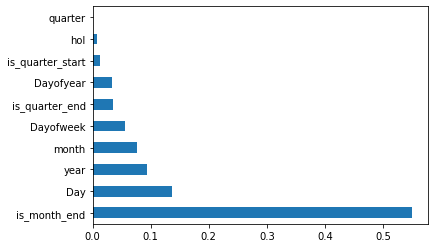

In [53]:
feat_imp = pd.Series(index = X_train_s1.columns,data = m1.feature_importances_)
feat_imp.nlargest(10).plot(kind = 'barh')

In [54]:
y_pred_xgb_s1

[array([ 1253.6432 ,   389.58737,  2627.5828 ,  2097.4753 ,  2403.2712 ,
         2348.8936 ,  3012.621  ,  2121.208  ,  1134.2349 ,  3344.5974 ,
         2884.477  ,  3081.5928 ,  2917.548  ,  2765.855  ,  1803.9641 ,
          824.5873 ,  3000.13   ,  2596.8433 ,  2802.6626 ,  2660.1653 ,
         2523.1228 ,  1793.4001 ,   801.38794,  3196.8025 ,  3041.0952 ,
         5220.861  ,  1920.4882 ,  1777.9714 ,  1632.0819 ,   500.04105,
         2767.9377 ,  2659.1323 ,  2721.3804 ,  2732.5645 ,  2610.5332 ,
         1988.5978 ,  1021.1376 ,  3917.6267 ,  3488.1582 ,  3649.4607 ,
         3283.1687 ,  3506.9102 ,  2686.596  ,  1699.6228 ,  3728.2454 ,
         3218.1416 ,  3459.0564 ,  3316.5593 ,  3298.8887 ,  2550.1558 ,
         1570.7776 ,  3442.5347 ,  3165.9255 ,  3374.1567 ,  3159.6475 ,
         3777.7913 ,  6762.9443 ,  -235.7671 ,  1670.14   ,  2623.0215 ,
         2703.7227 ,  2473.757  ,  2462.7334 ,  1921.7023 ,   934.7281 ,
         2580.3904 ,  2543.9841 ,  3357.6582 ,  392

In [55]:
fold = StratifiedKFold(n_splits = 2,shuffle = True,random_state = 1992)

In [56]:
for train_index, test_index in fold.split(X_train_s2,y_train_s2):
    X_train,X_test = X_train_s2.iloc[train_index],X_train_s2.iloc[test_index]
    y_train,y_test = y_train_s2.iloc[train_index],y_train_s2.iloc[test_index]
    m2 = XGBRegressor(n_estimators = 1500,random_state = 1991,learning_rate=0.1)
    m2.fit(X_train,y_train,eval_set = [(X_test,y_test)],early_stopping_rounds = 100)
    y_pred = m2.predict(X_test)
    print('MAPE',mean_absolute_percentage_error(y_test,y_pred))
    p = m2.predict(df_test_s2)
    y_pred_xgb_s2.append(p)

[11:21:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:16550.6
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\somal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
C:\Users\somal\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1]	validation_0-rmse:15077.5
[2]	validation_0-rmse:13788.1
[3]	validation_0-rmse:12609.6
[4]	validation_0-rmse:11601.5
[5]	validation_0-rmse:10690.8
[6]	validation_0-rmse:9864.72
[7]	validation_0-rmse:9149.46
[8]	validation_0-rmse:8535.65
[9]	validation_0-rmse:7945.78
[10]	validation_0-rmse:7428.8
[11]	validation_0-rmse:6995.11
[12]	validation_0-rmse:6609.45
[13]	validation_0-rmse:6258.83
[14]	validation_0-rmse:5969.34
[15]	validation_0-rmse:5731.15
[16]	validation_0-rmse:5505.38
[17]	validation_0-rmse:5293.39
[18]	validation_0-rmse:5090.71
[19]	validation_0-rmse:4950.01
[20]	validation_0-rmse:4816.71
[21]	validation_0-rmse:4714.94
[22]	validation_0-rmse:4603.2
[23]	validation_0-rmse:4524.12
[24]	validation_0-rmse:4456.18
[25]	validation_0-rmse:4375.55
[26]	validation_0-rmse:4299.05
[27]	validation_0-rmse:4230.08
[28]	validation_0-rmse:4188.48
[29]	validation_0-rmse:4135.11
[30]	validation_0-rmse:4121.58
[31]	validation_0-rmse:4072.68
[32]	validation_0-rmse:4017.18
[33]	validation_0-r

[262]	validation_0-rmse:3142.66
[263]	validation_0-rmse:3142.38
[264]	validation_0-rmse:3141.75
[265]	validation_0-rmse:3140.13
[266]	validation_0-rmse:3141.14
[267]	validation_0-rmse:3141.04
[268]	validation_0-rmse:3137.13
[269]	validation_0-rmse:3135.63
[270]	validation_0-rmse:3134.09
[271]	validation_0-rmse:3134.87
[272]	validation_0-rmse:3134.59
[273]	validation_0-rmse:3130.3
[274]	validation_0-rmse:3130.75
[275]	validation_0-rmse:3130.64
[276]	validation_0-rmse:3129.24
[277]	validation_0-rmse:3132.77
[278]	validation_0-rmse:3132.12
[279]	validation_0-rmse:3131.93
[280]	validation_0-rmse:3132.23
[281]	validation_0-rmse:3130.86
[282]	validation_0-rmse:3131.43
[283]	validation_0-rmse:3134.19
[284]	validation_0-rmse:3133
[285]	validation_0-rmse:3132.84
[286]	validation_0-rmse:3133.1
[287]	validation_0-rmse:3132.53
[288]	validation_0-rmse:3134.36
[289]	validation_0-rmse:3134.41
[290]	validation_0-rmse:3133.33
[291]	validation_0-rmse:3133.19
[292]	validation_0-rmse:3129.39
[293]	validat

[49]	validation_0-rmse:3574.15
[50]	validation_0-rmse:3558.63
[51]	validation_0-rmse:3546.14
[52]	validation_0-rmse:3540.2
[53]	validation_0-rmse:3532.3
[54]	validation_0-rmse:3529.94
[55]	validation_0-rmse:3527.5
[56]	validation_0-rmse:3506.83
[57]	validation_0-rmse:3499.2
[58]	validation_0-rmse:3493.89
[59]	validation_0-rmse:3479.71
[60]	validation_0-rmse:3481.97
[61]	validation_0-rmse:3472.62
[62]	validation_0-rmse:3468.5
[63]	validation_0-rmse:3469.9
[64]	validation_0-rmse:3469.89
[65]	validation_0-rmse:3462.1
[66]	validation_0-rmse:3455.72
[67]	validation_0-rmse:3448.82
[68]	validation_0-rmse:3442.32
[69]	validation_0-rmse:3433.73
[70]	validation_0-rmse:3433.16
[71]	validation_0-rmse:3420.54
[72]	validation_0-rmse:3418.62
[73]	validation_0-rmse:3393.67
[74]	validation_0-rmse:3390.09
[75]	validation_0-rmse:3394.14
[76]	validation_0-rmse:3389.67
[77]	validation_0-rmse:3387.02
[78]	validation_0-rmse:3384.71
[79]	validation_0-rmse:3375.09
[80]	validation_0-rmse:3377.29
[81]	validation

[308]	validation_0-rmse:3147.17
[309]	validation_0-rmse:3149.58
[310]	validation_0-rmse:3149.03
[311]	validation_0-rmse:3150.05
[312]	validation_0-rmse:3151.03
[313]	validation_0-rmse:3151.83
[314]	validation_0-rmse:3152.75
[315]	validation_0-rmse:3154.09
[316]	validation_0-rmse:3155.12
[317]	validation_0-rmse:3155.64
[318]	validation_0-rmse:3156.21
[319]	validation_0-rmse:3156.71
[320]	validation_0-rmse:3158.32
[321]	validation_0-rmse:3159.32
[322]	validation_0-rmse:3161.6
[323]	validation_0-rmse:3161.78
[324]	validation_0-rmse:3161.68
[325]	validation_0-rmse:3161.87
[326]	validation_0-rmse:3162.53
[327]	validation_0-rmse:3163.58
[328]	validation_0-rmse:3163.51
[329]	validation_0-rmse:3164.8
[330]	validation_0-rmse:3166.04
[331]	validation_0-rmse:3167.1
[332]	validation_0-rmse:3169.9
[333]	validation_0-rmse:3170.03
[334]	validation_0-rmse:3169.87
[335]	validation_0-rmse:3169.86
[336]	validation_0-rmse:3169.49
[337]	validation_0-rmse:3169.78
[338]	validation_0-rmse:3171.03
[339]	valida

## BEST MAPE for segment 2 using XGBOOST regression is 30.62

In [57]:
m2.feature_importances_

array([0.02987639, 0.5126665 , 0.02073233, 0.1545252 , 0.        ,
       0.06115307, 0.03338464, 0.        , 0.        , 0.00186034,
       0.18580157, 0.        , 0.        , 0.        ], dtype=float32)

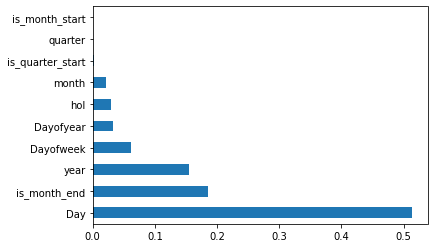

In [58]:
feat_imp = pd.Series(index = X_train_s2.columns,data = m2.feature_importances_)
feat_imp.nlargest(10).plot(kind = 'barh')

In [59]:
y_pred_xgb_s1_final = np.mean(y_pred_xgb_s1,0)
y_pred_xgb_s2_final = np.mean(y_pred_xgb_s2,0)

In [60]:
y_pred_xgb_s1_final

array([2055.803 , 1210.4497, 3200.152 , 2707.8975, 2882.573 , 2826.2812,
       3012.4714, 2242.726 , 1284.9056, 3382.5735, 2949.0989, 3068.3464,
       2962.0261, 2854.912 , 2066.4226, 1085.1381, 3182.1748, 2767.6448,
       2889.7932, 2789.6047, 2706.6238, 2047.8804, 1099.1576, 3253.9836,
       2826.8074, 5379.7427, 2046.7113, 1805.881 , 2035.9635, 1731.4935,
       3294.9324, 3033.3047, 3104.6592, 3031.2375, 2886.9954, 2301.7148,
       1357.0748, 3714.9844, 3348.5652, 3455.8748, 3287.0637, 3305.2854,
       2628.8516, 1670.7524, 3690.4968, 3201.8157, 3320.6418, 3220.4534,
       3150.369 , 2497.7952, 1524.5826, 3521.986 , 3163.4934, 3308.9854,
       3191.964 , 3326.4893, 8169.242 ,  811.2341, 2402.1975, 2840.4363,
       3080.344 , 3076.4219, 2983.742 , 2414.7903, 1419.8036, 3311.3625,
       3050.7168, 3599.1594, 3766.6318, 3658.8035, 3031.6672, 2149.441 ,
       4001.5222, 3692.6162, 3814.668 , 3809.3594, 3619.207 , 3139.168 ,
       2288.3533, 4088.5198, 3932.1677, 4134.23  , 

In [61]:
y_pred_xgb_s2_final

array([28407.994 , 26631.814 , 25251.    , 22312.82  , 13053.07  ,
       12075.709 , 10099.348 ,  3610.0898,  6236.9697,  5796.7744,
        4684.3115,  1027.5156,  5904.581 ,  5828.3926,  4186.5537,
        5054.992 ,  5457.107 ,  6283.2524,  7200.903 , 24912.727 ,
       28748.55  , 29451.938 , 24222.715 , 28490.838 , 28928.734 ,
       18164.982 , 30465.352 , 31266.89  , 29008.947 , 28117.475 ,
       27109.246 , 25365.934 , 17135.582 , 23027.973 , 23182.324 ,
       18645.367 , 12234.342 ,  8468.394 ,  2057.4448,  1065.1245,
        5124.625 ,  5422.258 ,  5360.915 ,  5156.2124,  5010.6016,
        4723.709 ,  1153.0103,  6021.8726,  7854.6074, 18209.75  ,
       24700.13  , 26845.234 , 26674.445 , 15992.236 , 28299.564 ,
       30086.69  , 29155.902 , 29537.627 , 29741.383 , 27684.166 ,
       17062.96  , 27676.06  , 27166.209 , 25628.29  , 24288.207 ,
       21457.545 , 16496.26  ,  4828.579 ,  3657.587 ,  5457.0146,
        4520.866 ,  4783.081 ,  4755.105 ,  4536.71  ,  1008.6

In [62]:
df_test_s2

,hol,Day,month,year,quarter,Dayofweek,Dayofyear,is_month_start,is_year_start,is_quarter_start,is_month_end,is_year_end,is_quarter_end,Semester
87,False,24,7,2019,3,2,205,False,False,False,False,False,False,2
88,False,25,7,2019,3,3,206,False,False,False,False,False,False,2
89,False,26,7,2019,3,4,207,False,False,False,False,False,False,2
90,False,27,7,2019,3,5,208,False,False,False,False,False,False,2
91,False,28,7,2019,3,6,209,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,False,20,10,2019,4,6,293,False,False,False,False,False,False,2
176,False,21,10,2019,4,0,294,False,False,False,False,False,False,2
177,False,22,10,2019,4,1,295,False,False,False,False,False,False,2
178,False,23,10,2019,4,2,296,False,False,False,False,False,False,2


In [63]:
from lightgbm import LGBMRegressor

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X_train_s1,y_train_s1,test_size = 0.3,random_state = 1991)

## Building model using LGBM for segment 1

In [66]:
m3 = LGBMRegressor(n_estimators = 1500,random_state=1992)
m3.fit(X_train,y_train,eval_set = [(X_test,y_test)],early_stopping_rounds = 100)

[1]	valid_0's l2: 4.10711e+06
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 3.83393e+06
[3]	valid_0's l2: 3.60211e+06
[4]	valid_0's l2: 3.40668e+06
[5]	valid_0's l2: 3.2502e+06
[6]	valid_0's l2: 3.12431e+06
[7]	valid_0's l2: 3.00579e+06
[8]	valid_0's l2: 2.90462e+06
[9]	valid_0's l2: 2.82082e+06
[10]	valid_0's l2: 2.76228e+06
[11]	valid_0's l2: 2.70972e+06
[12]	valid_0's l2: 2.6579e+06
[13]	valid_0's l2: 2.64366e+06
[14]	valid_0's l2: 2.6037e+06
[15]	valid_0's l2: 2.60817e+06
[16]	valid_0's l2: 2.56816e+06
[17]	valid_0's l2: 2.58885e+06
[18]	valid_0's l2: 2.562e+06
[19]	valid_0's l2: 2.56997e+06
[20]	valid_0's l2: 2.54723e+06
[21]	valid_0's l2: 2.55321e+06
[22]	valid_0's l2: 2.53793e+06
[23]	valid_0's l2: 2.54369e+06
[24]	valid_0's l2: 2.52701e+06
[25]	valid_0's l2: 2.53382e+06
[26]	valid_0's l2: 2.52271e+06
[27]	valid_0's l2: 2.5271e+06
[28]	valid_0's l2: 2.51347e+06
[29]	valid_0's l2: 2.5003e+06
[30]	valid_0's l2: 2.51665e+06
[31]	valid_0's l2: 2.498

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1992, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
y_pred = m3.predict(X_test)

In [68]:
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

MAPE 566.9222853530673


## MAPE using LGBM regression for segement 1 is 566.9

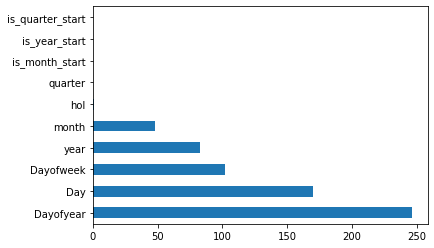

In [69]:
feat_imp = pd.Series(index = X_train_s1.columns,data = m3.feature_importances_)
feat_imp.nlargest(10).plot(kind = 'barh')

In [70]:
y_pred_lgbm_s1 = m3.predict(df_test_s1)

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X_train_s2,y_train_s2,test_size = 0.3,random_state = 1991)

In [72]:
m4 = LGBMRegressor(n_estimator = 1500,random_state = 1991)

In [73]:
m4.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100)

[1]	valid_0's l2: 8.82752e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 7.48986e+07
[3]	valid_0's l2: 6.40559e+07
[4]	valid_0's l2: 5.52485e+07
[5]	valid_0's l2: 4.81008e+07
[6]	valid_0's l2: 4.19411e+07
[7]	valid_0's l2: 3.69901e+07
[8]	valid_0's l2: 3.28224e+07
[9]	valid_0's l2: 2.92717e+07
[10]	valid_0's l2: 2.65708e+07
[11]	valid_0's l2: 2.40517e+07
[12]	valid_0's l2: 2.19554e+07
[13]	valid_0's l2: 2.02856e+07
[14]	valid_0's l2: 1.89235e+07
[15]	valid_0's l2: 1.76165e+07
[16]	valid_0's l2: 1.64051e+07
[17]	valid_0's l2: 1.54044e+07
[18]	valid_0's l2: 1.4468e+07
[19]	valid_0's l2: 1.37985e+07
[20]	valid_0's l2: 1.31714e+07
[21]	valid_0's l2: 1.271e+07
[22]	valid_0's l2: 1.21846e+07
[23]	valid_0's l2: 1.18458e+07
[24]	valid_0's l2: 1.15045e+07
[25]	valid_0's l2: 1.12007e+07
[26]	valid_0's l2: 1.09729e+07
[27]	valid_0's l2: 1.07849e+07
[28]	valid_0's l2: 1.05586e+07
[29]	valid_0's l2: 1.0463e+07
[30]	valid_0's l2: 1.03017e+07
[31]	valid_0's l2: 1.

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimator=1500, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=1991, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [74]:
y_pred = m4.predict(X_test)

In [75]:
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

MAPE 22.218817525197757


## MAPE using LGBM regression for segement 2 is 22.2

In [76]:
y_pred_lgbm_s2 = m4.predict(df_test_s2)

## stacking XGBOOST and LGBM model for seg1 

In [77]:
s1_final  = (y_pred_xgb_s1_final + y_pred_lgbm_s1)/2
s1_final

array([2248.11412852, 1321.93173454, 3517.64738297, 3092.31666012,
       3137.10249193, 2950.90525185, 3000.32952627, 2344.94963548,
       1396.06266187, 3527.46143996, 3130.63193322, 3182.17915225,
       3031.75262179, 2898.74218528, 2224.39677881, 1255.20343579,
       3367.87750366, 2960.31709646, 3027.58630558, 2919.55903071,
       2839.82390998, 2233.90737397, 1289.40494527, 3276.74788319,
       4173.64947396, 5450.11712533, 1997.7192317 , 1800.98431816,
       2348.5989147 , 1747.4068902 , 3629.31517247, 3332.25316861,
       3359.02087941, 3135.69793497, 2984.87582862, 2398.12114237,
       1423.54066191, 3793.57523467, 3466.0733889 , 3497.35769723,
       3294.6667414 , 3255.37702009, 2677.27569077, 1645.27839862,
       3688.8237939 , 3290.4412625 , 3360.05839689, 3238.3291575 ,
       3162.44585858, 2557.16711117, 1530.09595466, 3617.14923887,
       3265.34640998, 3357.54277943, 3066.8148715 , 4402.41571468,
       6823.79217953, 1038.6290131 , 2494.22654164, 3007.73475

## stacking XGBOOST and LGBM model for seg2

In [78]:
s2_final = (y_pred_xgb_s2_final + y_pred_lgbm_s2)/2

In [79]:
final_s1 = pd.DataFrame()

In [80]:
final_s1['id'] = df_test[df_test['segment'] == 1]['id']
final_s1['application_date']  = df_test[df_test['segment'] == 1]['application_date']
final_s1['segment']  = df_test[df_test['segment'] == 1]['segment']
final_s1['case_count']  = s1_final

In [81]:
final_s1

,id,application_date,segment,case_count
0,1,2019-07-06,1,2248.114129
1,2,2019-07-07,1,1321.931735
2,3,2019-07-08,1,3517.647383
3,4,2019-07-09,1,3092.316660
4,5,2019-07-10,1,3137.102492
...,...,...,...,...
82,83,2019-09-26,1,3617.186172
83,84,2019-09-27,1,3541.646152
84,85,2019-09-28,1,3420.865263
85,86,2019-09-29,1,2913.802952


In [82]:
final_s2 = pd.DataFrame()
final_s2['id'] = df_test[df_test['segment'] == 2]['id']
final_s2['application_date']  = df_test[df_test['segment'] == 2]['application_date']
final_s2['segment']  = df_test[df_test['segment'] == 2]['segment']
final_s2['case_count']  = s2_final

In [83]:
final_s2

,id,application_date,segment,case_count
87,88,2019-07-24,2,28286.549941
88,89,2019-07-25,2,26461.839393
89,90,2019-07-26,2,24476.962516
90,91,2019-07-27,2,21541.302068
91,92,2019-07-28,2,13831.691578
...,...,...,...,...
175,176,2019-10-20,2,11689.741852
176,177,2019-10-21,2,23270.726438
177,178,2019-10-22,2,25133.411851
178,179,2019-10-23,2,28035.052854


In [84]:
final_s1.append(final_s2)

,id,application_date,segment,case_count
0,1,2019-07-06,1,2248.114129
1,2,2019-07-07,1,1321.931735
2,3,2019-07-08,1,3517.647383
3,4,2019-07-09,1,3092.316660
4,5,2019-07-10,1,3137.102492
...,...,...,...,...
175,176,2019-10-20,2,11689.741852
176,177,2019-10-21,2,23270.726438
177,178,2019-10-22,2,25133.411851
178,179,2019-10-23,2,28035.052854


## TIME SERIES MODELLING USING SA,MA,SES,HOLT,HOLTWINTERS,ARIMA,SARIMAX,FACEBOOKPROPHET 

In [85]:
df_train_s1_ar = df_train_seg1.groupby(['application_date']).agg({'case_count': 'sum'}).reset_index()
df_train_s2_ar = df_train_seg2.groupby(['application_date']).agg({'case_count': 'sum'}).reset_index()
df_test_s1_ar = df_test[df_test['segment'] == 1]
df_test_s2_ar = df_test[df_test['segment'] == 2]

In [86]:
df_train_s1_ar['hol'] = df_train_s1_ar['application_date'].isin(hol)
df_train_s2_ar['hol'] = df_train_s2_ar['application_date'].isin(hol)
df_test_s1_ar['hol'] = df_test_s1_ar['application_date'].isin(hol)
df_test_s2_ar['hol'] = df_test_s2_ar['application_date'].isin(hol)


C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [87]:
df_train_s1_ar=df_train_s1_ar.set_index('application_date')


In [88]:
df_train_s2_ar=df_train_s2_ar.set_index('application_date')
df_test_s1_ar=df_test_s1_ar.set_index('application_date')


In [89]:
df_test_s2_ar=df_test_s2_ar.set_index('application_date')

In [90]:
df_train_s1_ar

,case_count,hol
application_date,,
2017-04-01,299.0,False
2017-04-03,42.0,False
2017-04-04,23.0,False
2017-04-05,1530.0,True
2017-04-07,1341.0,False
...,...,...
2019-07-01,3650.0,False
2019-07-02,3212.0,False
2019-07-03,3824.0,False


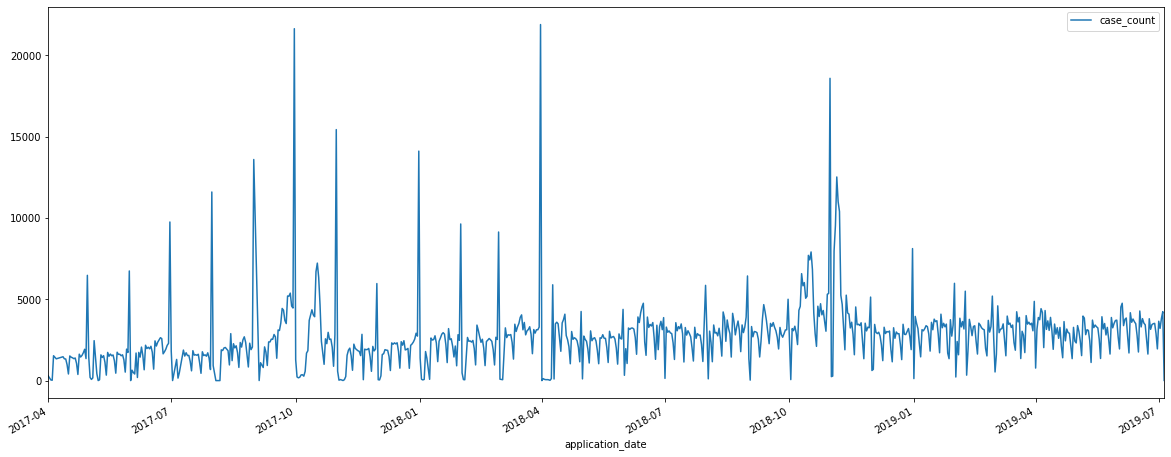

In [91]:
df_train_s1_ar.plot(figsize = (20,8))

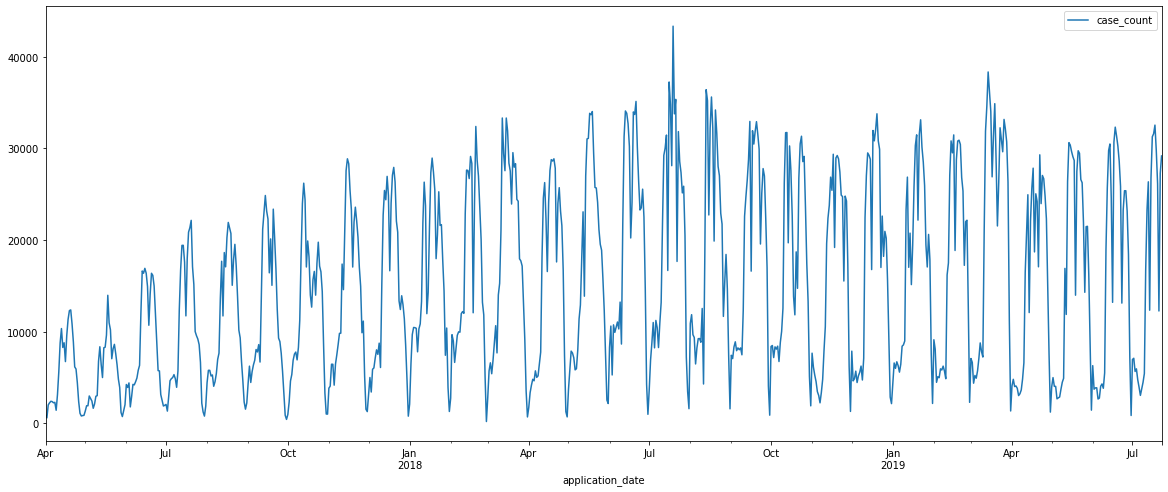

In [92]:
df_train_s2_ar.plot(figsize = (20,8))

## UNDERSTANDING SEASONALITY, TREND USING SEASONAL DECOMPOSE

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [94]:
s1 = seasonal_decompose(x = df_train_s1_ar['case_count'],model = 'additive',freq = 7)

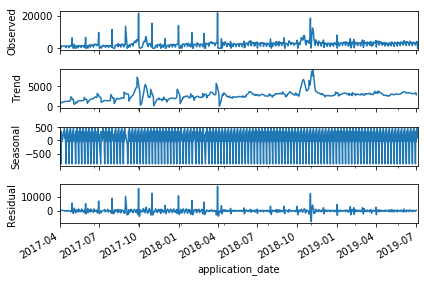

In [95]:
s1.plot();

In [96]:
df_ts = pd.DataFrame()
df_ts['trend'] = s1.trend
df_ts['seasonal'] = s1.seasonal

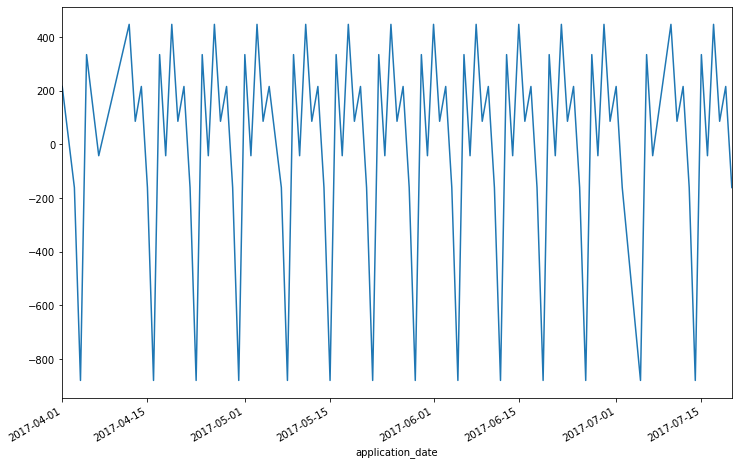

In [97]:
df_ts['seasonal'].iloc[:100].plot(figsize = (12,8))

## WEEKLY SEASONALITY IS PRESENT IN SEGMENT 1

In [98]:
df_ts.head(31)

,trend,seasonal
application_date,,
2017-04-01,NaN,215.649017
2017-04-03,NaN,-161.011384
2017-04-04,NaN,-879.770783
2017-04-05,863.285714,334.388147
2017-04-07,1010.571429,-42.317443
2017-04-12,1144.714286,447.133979
2017-04-13,1199.857143,85.928466
2017-04-14,1197.714286,215.649017
2017-04-15,1212.142857,-161.011384


## with seasonal decomposition we can see that seasonality is present in the TS. Lets start  with SARIMAX (i.e ARIMA model with seasonal component and exogenous variable - holiday), but first we will check stationarity, because basic assumption in arima  based models is that data is stationary 

In [99]:
#Dickey Fuller Test, to check stationarity
from statsmodels.tsa.stattools import adfuller

In [100]:
adfuller(df_train_s1_ar['case_count'])

(-4.5509924837755245,
 0.0001588757821399685,
 13,
 792,
 {'1%': -3.438633612472885,
  '5%': -2.865196199232788,
  '10%': -2.5687169024206713},
 14111.927169892495)

## p value is less than 0.05, therefore we will reject the null hypothesis (at 95% confidence) that it is 'non stationary', data is staionary. Even with 99% confidence we can say , data is stationary.
## Therefore we can go aheah with model buiding

In [101]:
from pmdarima import auto_arima

In [102]:
df_train_s1_ar

,case_count,hol
application_date,,
2017-04-01,299.0,False
2017-04-03,42.0,False
2017-04-04,23.0,False
2017-04-05,1530.0,True
2017-04-07,1341.0,False
...,...,...
2019-07-01,3650.0,False
2019-07-02,3212.0,False
2019-07-03,3824.0,False


In [103]:
df_train_s1_ar['holiday'] = df_train_s1_ar['hol'].apply(lambda x: 1 if x == True else 0)
df_test_s1_ar['holiday'] = df_test_s1_ar['hol'].apply(lambda x: 1 if x == True else 0)

## Getting the orders of ARIMA model with seasonal set to True and m (period of session) equal to 7, and exogenous holiday variable

In [104]:
orders = auto_arima(df_train_s1_ar['case_count'],exogenous=df_train_s1_ar[['holiday']],seasonal = True,m=7)

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\somal\Anaconda3\lib\site-pa

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\somal\Anaconda3\lib\site-pa

In [105]:
orders.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  806
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -7217.627
Date:                           Sat, 29 Feb 2020   AIC                          14449.254
Time:                                   11:23:18   BIC                          14482.090
Sample:                                        0   HQIC                         14461.865
                                           - 806                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0524      0.255      0.206      0.837      -0.447       0.551
holiday      323.8518    224.207      1.444      0.149    -115.585     763.289
ar.L1          0.1248      0.022      5.635      0.000       0.081       0.168
ma.L1         -0.9503      0.012    -82.596      0.000      -0.973      -0.928
ar.S.L7        0.9788      0.026     38.296      0.000       0.929       1.029
ma.S.L7       -0.9384      0.038    -24.546      0.000      -1.013      -0.863
sigma2      3.577e+06   6.38e+04     56.071      0.000    3.45e+06     3.7e+06
===================================================================================
Ljung-Box (Q):                       54.77   Jarque-Bera (JB):             36425.85
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             3.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## order of ARIMA i.e p,d, q is (1,1,1) and order of seasonal component i.e P, D,Q is (1,0,1,7)

In [106]:
df_train_s1_ar

,case_count,hol,holiday
application_date,,,
2017-04-01,299.0,False,0
2017-04-03,42.0,False,0
2017-04-04,23.0,False,0
2017-04-05,1530.0,True,1
2017-04-07,1341.0,False,0
...,...,...,...
2019-07-01,3650.0,False,0
2019-07-02,3212.0,False,0
2019-07-03,3824.0,False,0


## As final test data is of length 87 days, we will to do train test split having test data minimun 87 data point. Lets have 100 days for testing.

In [107]:
train = df_train_s1_ar[:len(df_train_s1_ar)-100]
test = df_train_s1_ar[len(df_train_s1_ar)-100:]

In [108]:
test

,case_count,hol,holiday
application_date,,,
2019-03-28,3439.0,True,1
2019-03-29,3528.0,False,0
2019-03-30,3063.0,False,0
2019-03-31,4871.0,False,0
2019-04-01,772.0,False,0
...,...,...,...
2019-07-01,3650.0,False,0
2019-07-02,3212.0,False,0
2019-07-03,3824.0,False,0


In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [110]:
train['holiday']

application_date
2017-04-01    0
2017-04-03    0
2017-04-04    0
2017-04-05    1
2017-04-07    0
             ..
2019-03-23    0
2019-03-24    0
2019-03-25    0
2019-03-26    0
2019-03-27    0
Name: holiday, Length: 706, dtype: int64

In [111]:
model = SARIMAX(train['case_count'],exog = train['holiday'],order=(1,1,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [112]:
result_s1 = model.fit()

In [113]:
result_s1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        case_count   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6368.095
Date:                           Sat, 29 Feb 2020   AIC                          12748.189
Time:                                   11:23:21   BIC                          12775.538
Sample:                                        0   HQIC                         12758.758
                                           - 706                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      477.0611    301.975      1.580      0.114    -114.800    1068.922
ar.L1          0.1296      0.031      4.225      0.000       0.069       0.190
ma.L1         -0.9509      0.016    -61.275      0.000      -0.981      -0.920
ar.S.L7        0.9690      0.047     20.490      0.000       0.876       1.062
ma.S.L7       -0.9260      0.066    -13.992      0.000      -1.056      -0.796
sigma2      4.916e+06   9.52e+04     51.632      0.000    4.73e+06     5.1e+06
===================================================================================
Ljung-Box (Q):                       47.91   Jarque-Bera (JB):             25658.99
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             3.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
start = len(train)
end = len(train) + len(test) -1
y_pred = result_s1.predict(start = start,end = end,exog = test[['holiday']]).rename('predicted')

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [115]:
y_pred

706    3625.882885
707    3060.963896
708    2524.348907
709    2184.807287
710    3532.443415
          ...     
801    3269.793190
802    2949.529947
803    3141.789067
804    2987.446187
805    2947.963546
Name: predicted, Length: 100, dtype: float64

In [116]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],y_pred))

MAPE: 246.64410445354892


## MAPE using SARIMAX model for segment 1 is 246, better than regression based model

In [117]:
y_pred.index = test.index

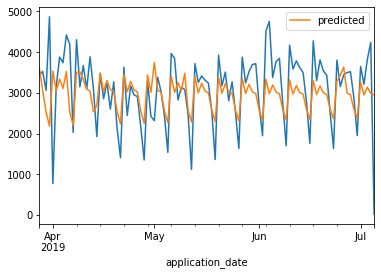

In [118]:
test['case_count'].plot()
y_pred.plot(legend = True)

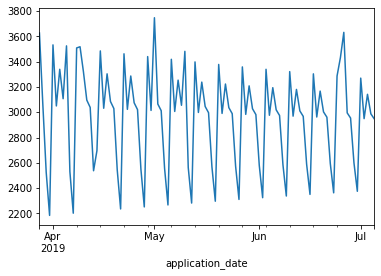

In [119]:
y_pred.plot()

## Retrain the final model using complete dataset for final prediction

In [120]:
model_final_s1 = SARIMAX(df_train_s1_ar['case_count'],exog =df_train_s1_ar['holiday'],order=(1,1,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [121]:
result_final_s1 = model_final_s1.fit()
result_final_s1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        case_count   No. Observations:                  806
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -7226.196
Date:                           Sat, 29 Feb 2020   AIC                          14464.391
Time:                                   11:23:24   BIC                          14492.536
Sample:                                        0   HQIC                         14475.200
                                           - 806                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      326.9737    274.150      1.193      0.233    -210.351     864.298
ar.L1          0.1243      0.027      4.524      0.000       0.070       0.178
ma.L1         -0.9496      0.014    -68.014      0.000      -0.977      -0.922
ar.S.L7        0.9772      0.033     29.303      0.000       0.912       1.043
ma.S.L7       -0.9366      0.049    -18.960      0.000      -1.033      -0.840
sigma2      4.426e+06   7.64e+04     57.924      0.000    4.28e+06    4.58e+06
===================================================================================
Ljung-Box (Q):                       54.69   Jarque-Bera (JB):             36356.51
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             3.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
start = len(df_train_s1_ar)
end = len(df_train_s1_ar) + len(df_test_s1_ar)-1

## forecasting future based on final trained model for segment 1

In [123]:
y_pred_s1 = result_final_s1.predict(start = start,end = end,exog = df_test_s1_ar[['holiday']]).rename('predicted')

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [124]:
y_pred_s1.index = df_test_s1_ar.index

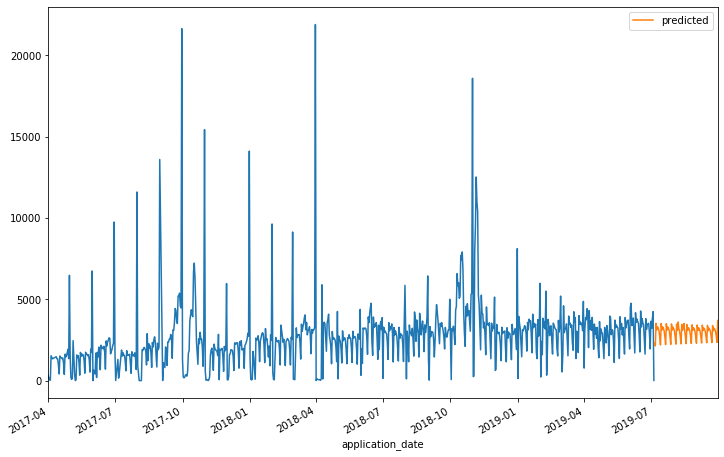

In [125]:
df_train_s1_ar['case_count'].plot(figsize = (12,8))
y_pred_s1.plot(legend = True)

## lets build simpler model , SA, MA, SES, HOLT, HOLTWINTER and compare the MAPE for segment 1

In [126]:
# Simple Average
test['SA'] = train['case_count'].mean()

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


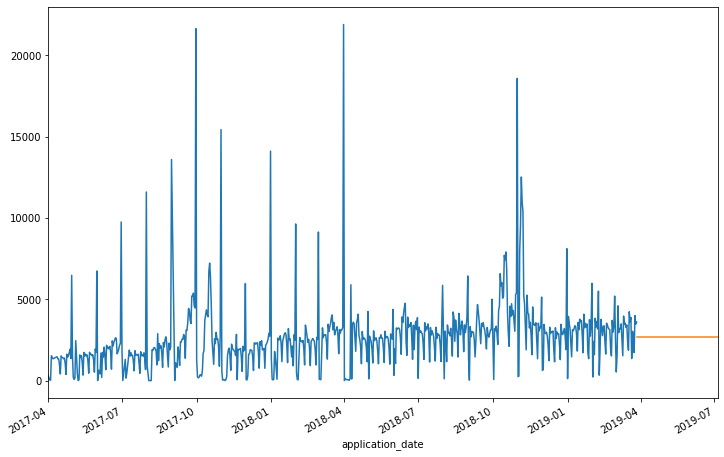

In [127]:
train['case_count'].plot(figsize = (12,8))
test['SA'].plot()

In [128]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['SA']))

MAPE: 233.06207333065444


## Simple average model MAPE for segment_1 = 233.06

In [129]:
test['MA'] = train['case_count'].rolling(60).mean().iloc[-1]

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


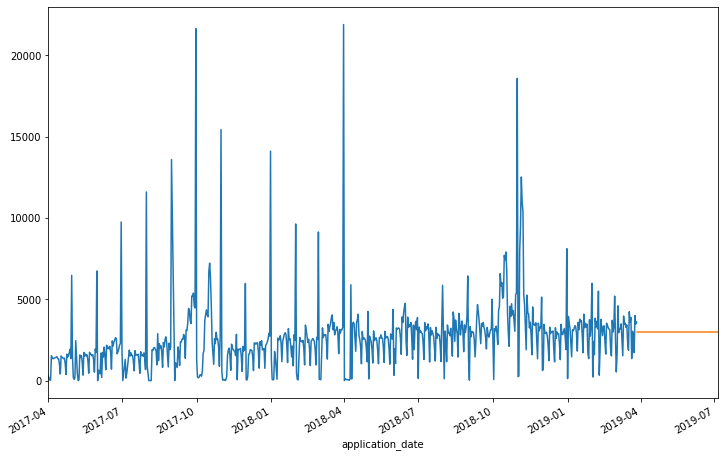

In [130]:
train['case_count'].plot(figsize = (12,8))
test['MA'].plot()

In [131]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['MA']))

MAPE: 255.9068368493186


## MAPE using Moving Average wth 60 days rolling window = 255.90

In [132]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [133]:
fit_se = SimpleExpSmoothing(np.array(train['case_count'])).fit()
test['SES'] = fit_se.forecast(len(test))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


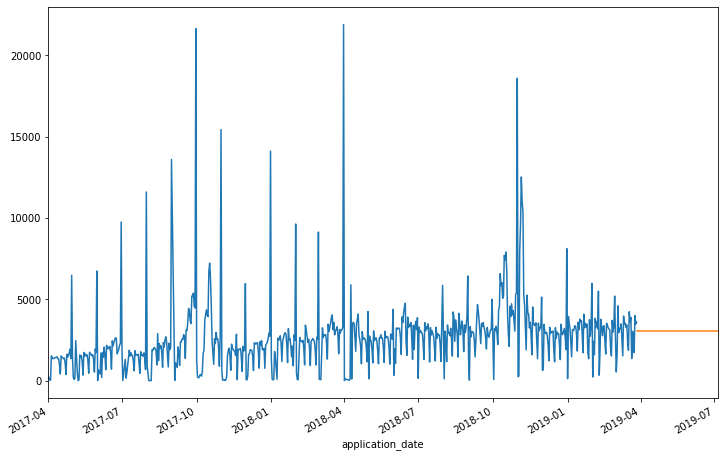

In [134]:
train['case_count'].plot(figsize = (12,8))
test['SES'].plot()

In [135]:
test

,case_count,hol,holiday,SA,MA,SES
application_date,,,,,,
2019-03-28,3439.0,True,1,2662.022663,2976.55,3046.590002
2019-03-29,3528.0,False,0,2662.022663,2976.55,3046.590002
2019-03-30,3063.0,False,0,2662.022663,2976.55,3046.590002
2019-03-31,4871.0,False,0,2662.022663,2976.55,3046.590002
2019-04-01,772.0,False,0,2662.022663,2976.55,3046.590002
...,...,...,...,...,...,...
2019-07-01,3650.0,False,0,2662.022663,2976.55,3046.590002
2019-07-02,3212.0,False,0,2662.022663,2976.55,3046.590002
2019-07-03,3824.0,False,0,2662.022663,2976.55,3046.590002


In [136]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['SES']))

MAPE: 261.2368342516537


## MAPE using Simple exponential smoothening is 261.23 for segement 1

In [137]:
fit_se.model.params

{'smoothing_level': 0.0687386709408235,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 1113.9221279921371,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [138]:
fit_se1 = SimpleExpSmoothing(np.asarray(train['case_count'])).fit(smoothing_level=0.6,optimized=False)
test['SES_0.6'] = fit_se1.forecast(len(test))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


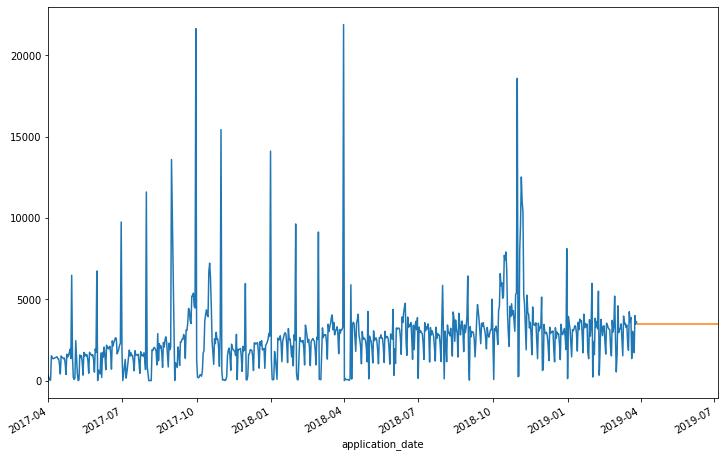

In [139]:
train['case_count'].plot(figsize = (12,8))
test['SES_0.6'].plot()

In [140]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['SES_0.6']))

MAPE: 301.0628675497407


## MAPE using 60% smoothening level  (to latest data point) is  = 301.06

In [141]:
h = Holt(np.array(train['case_count'])).fit(smoothing_level = 0.03, smoothing_slope = 0.01)
test['holt'] = h.forecast(len(test))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


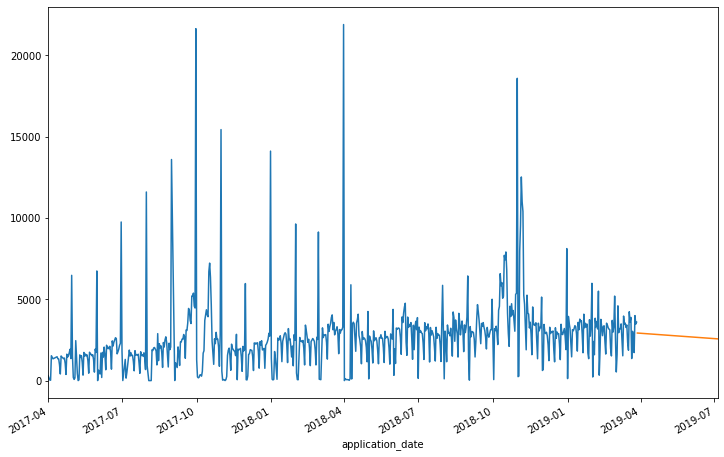

In [142]:
train['case_count'].plot(figsize = (12,8))
test['holt'].plot()

In [143]:
test

,case_count,hol,holiday,SA,MA,SES,SES_0.6,holt
application_date,,,,,,,,
2019-03-28,3439.0,True,1,2662.022663,2976.55,3046.590002,3510.29456,2925.315734
2019-03-29,3528.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2921.698016
2019-03-30,3063.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2918.080298
2019-03-31,4871.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2914.462580
2019-04-01,772.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2910.844862
...,...,...,...,...,...,...,...,...
2019-07-01,3650.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2581.632528
2019-07-02,3212.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2578.014810
2019-07-03,3824.0,False,0,2662.022663,2976.55,3046.590002,3510.29456,2574.397092


In [144]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['holt']))

MAPE: 225.52996170364733


## MAPE using HOLT method (double exponential smoothening,which adds trend component) is  = 225.52

In [145]:
h.model.params

{'smoothing_level': 0.03,
 'smoothing_slope': 0.01,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 1132.799702428393,
 'initial_slope': 7.9352281833191824,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [146]:
E1 = ExponentialSmoothing(np.array(train['case_count']),trend='add',seasonal='add',seasonal_periods=7).fit()
test['HW'] = E1.forecast(len(test))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


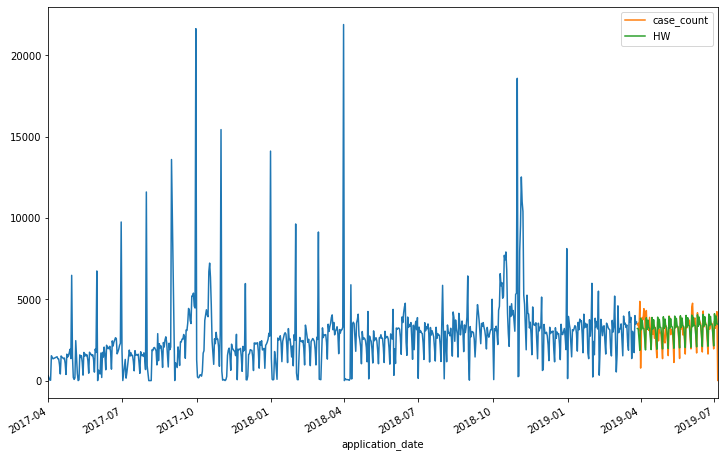

In [147]:
train['case_count'].plot(figsize = (12,8))
test['case_count'].plot(legend = True)
test['HW'].plot(legend = True)

In [148]:
print('MAPE:', mean_absolute_percentage_error(test['case_count'],test['HW']))

MAPE: 282.79949151299985


## MAPE using Holt winters methods  = 282.79 segment 1

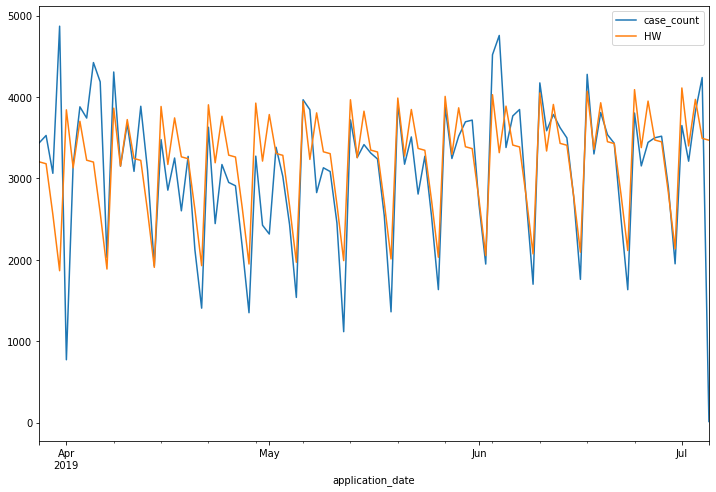

In [149]:
test['case_count'].plot(figsize = (12,8),legend = True)
test['HW'].plot(legend = True)

## building model using FBProphet

In [150]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [151]:
df_train_s1_fb = df_train_s1_ar

In [152]:
df_train_s1_fb.drop(columns = ['hol','holiday'], inplace = True)

In [153]:
df_train_s1_fb = df_train_s1_fb.reset_index()

In [154]:
df_train_s1_fb.columns = ['ds','y']

In [155]:
train_s1_fb = df_train_s1_fb[:len(df_train_s1_fb)-100]
test_s1_fb = df_train_s1_fb[len(df_train_s1_fb)-100:]

In [156]:
m1 = Prophet()

In [157]:
m1.fit(train_s1_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [158]:
future_s1 = m1.make_future_dataframe(len(test_s1_fb))

In [159]:
test_s1_forecast = m1.predict(future_s1)

In [160]:
pred_s1 = test_s1_forecast[len(test_s1_forecast)-100:]

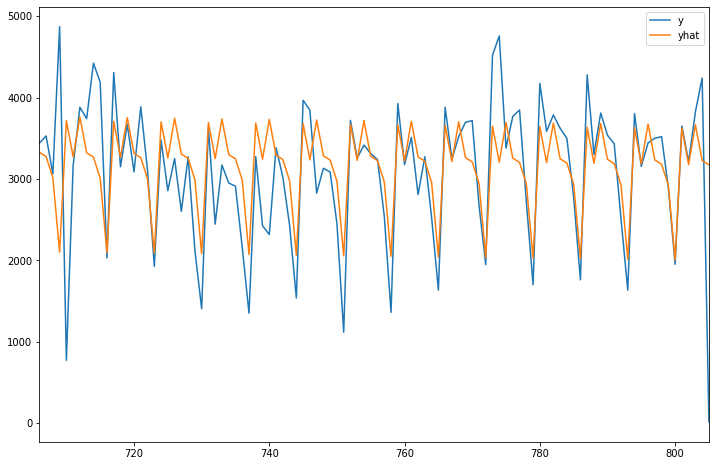

In [161]:
test_s1_fb['y'].plot(figsize = (12,8),legend = True)
pred_s1['yhat'].plot(figsize = (12,8),legend = True)

In [162]:
print('MAPE:', mean_absolute_percentage_error(test_s1_fb['y'],pred_s1['yhat']))

MAPE: 260.83631098186476


## MAPE using FBProphet for segment is 260.83

## Building model for Segment 2

In [163]:
df_train_s2_ar

,case_count,hol
application_date,,
2017-04-01,897.0,False
2017-04-02,605.0,False
2017-04-03,2016.0,False
2017-04-04,2245.0,False
2017-04-05,2415.0,True
...,...,...
2019-07-19,29778.0,False
2019-07-20,26123.0,False
2019-07-21,12267.0,False


## Using seasonal decompose to understand trend, seasonality and noise
## passing freq as 7 (as it is daily data), i.e The freq parameter expects an integer describing the periodicity of the seasonality.

In [164]:
s2_dec = seasonal_decompose(x = df_train_s2_ar['case_count'], model = 'additive', freq = 7)

In [167]:
pd.plotting.register_matplotlib_converters() # because unusual behaviour of PANDA which was throwing error "TypeError: float() argument must be a string or a number, not 'Period'""

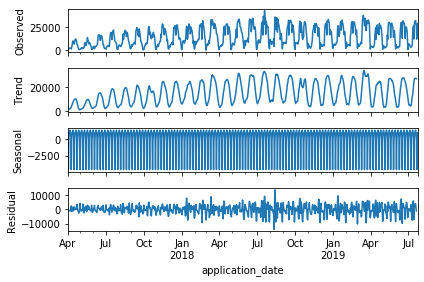

In [169]:
s2_dec.plot();

In [170]:
ts_s = pd.DataFrame()
ts_s['trend'] = s2_dec.trend
ts_s['Season'] = s2_dec.seasonal

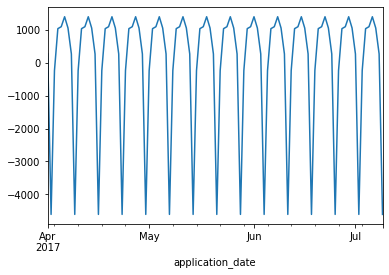

In [171]:
ts_s['Season'].iloc[:100].plot()

In [172]:
adfuller(df_train_s2_ar['case_count'])

(-4.359218619180237,
 0.0003502438078567953,
 21,
 822,
 {'1%': -3.4383303387882793,
  '5%': -2.8650625183820577,
  '10%': -2.5686456901154977},
 16020.735404736115)

## Data is stationary as per above dickey fuller test
## lets split into train test

In [173]:
df_train_s2_ar['holiday'] = df_train_s2_ar['hol'].apply(lambda x: 1 if x == True else 0)

In [174]:
train_2 = df_train_s2_ar.iloc[:len(df_train_s2_ar)-100]
test_2 = df_train_s2_ar.iloc[len(df_train_s2_ar)-100:]

In [175]:
train_2

,case_count,hol,holiday
application_date,,,
2017-04-01,897.0,False,0
2017-04-02,605.0,False,0
2017-04-03,2016.0,False,0
2017-04-04,2245.0,False,0
2017-04-05,2415.0,True,1
...,...,...,...
2019-04-10,6612.0,False,0
2019-04-11,16480.0,False,0
2019-04-12,20638.0,False,0


In [176]:
test_2['SA'] = train_2['case_count'].mean()
test_2['MA'] = train_2['case_count'].rolling(10).mean().iloc[-1]
SES_model = SimpleExpSmoothing(np.array(train_2['case_count'])).fit()
test_2['SES'] = SES_model.forecast(len(test))
holt_model = Holt(np.array(train_2['case_count'])).fit()
test_2['Holt'] = holt_model.forecast(len(test_2))
HW_model = ExponentialSmoothing(np.array(train_2['case_count']),seasonal_periods=7, seasonal='add').fit()
test_2['HW'] = HW_model.forecast(len(test_2))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

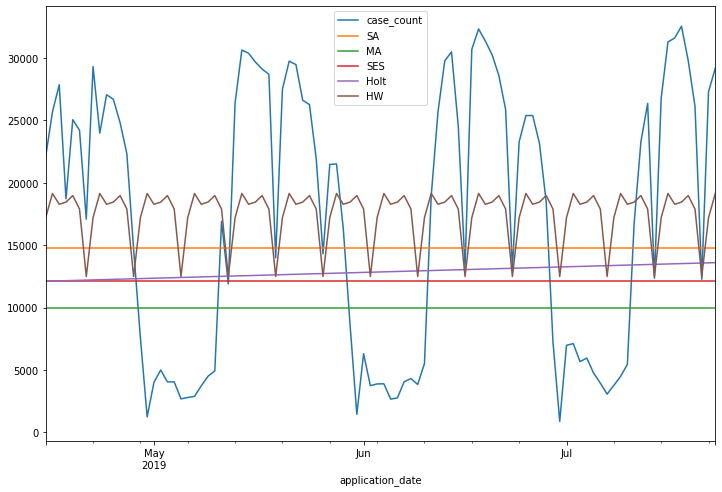

In [177]:
#train_2['case_count'].plot(figsize = (12,8),legend = True)
test_2['case_count'].plot(figsize = (12,8),legend = True)
test_2['SA'].plot(legend = True)
test_2['MA'].plot(legend = True)
test_2['SES'].plot(legend = True)
test_2['Holt'].plot(legend = True)
test_2['HW'].plot(legend = True)

## looking at the above, it is inferred that data has weekly as well as monthly seasonality, i.e multiple seasonality

In [178]:
for i in ['SA', 'MA', 'SES', 'Holt', 'HW']:
    print('MAPE_'+i, mean_absolute_percentage_error(test_2['case_count'],test_2[i]))

MAPE_SA 142.71317199177616
MAPE_MA 103.68827691363866
MAPE_SES 120.15134743540506
MAPE_Holt 126.31732336943229
MAPE_HW 158.9541417243025


## MAPE for various models for segment 2 is as above, best is moving average

In [179]:
test_2.columns

Index(['case_count', 'hol', 'holiday', 'SA', 'MA', 'SES', 'Holt', 'HW'], dtype='object')

## Lets try building model using SARIMAX, lets get the orders using auto_arima

In [180]:
orders_2 = auto_arima(df_train_s2_ar['case_count'],exogenous=df_train_s2_ar[['holiday']],seasonal = True,m=7)

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [181]:
orders_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  844
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -8248.188
Date:                           Sat, 29 Feb 2020   AIC                          16518.375
Time:                                   11:25:36   BIC                          16570.482
Sample:                               04-01-2017   HQIC                         16538.343
                                    - 07-23-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     32.0761     59.581      0.538      0.590     -84.700     148.852
holiday    -1439.1496    665.137     -2.164      0.030   -2742.794    -135.505
ar.L1         -1.0188      0.065    -15.603      0.000      -1.147      -0.891
ar.L2         -0.8795      0.063    -14.032      0.000      -1.002      -0.757
ma.L1          1.0593      0.054     19.720      0.000       0.954       1.165
ma.L2          0.9358      0.051     18.386      0.000       0.836       1.036
ar.S.L7        0.3344      0.159      2.098      0.036       0.022       0.647
ar.S.L14       0.6570      0.155      4.230      0.000       0.353       0.961
ma.S.L7       -0.1708      0.142     -1.199      0.231      -0.450       0.108
ma.S.L14      -0.7371      0.120     -6.167      0.000      -0.971      -0.503
sigma2      2.458e+07      0.037   6.73e+08      0.000    2.46e+07    2.46e+07
===================================================================================
Ljung-Box (Q):                      381.53   Jarque-Bera (JB):               132.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.85   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.65e+23. Standard errors may be unstable.
"""

In [182]:
sarima_model = SARIMAX(train_2['case_count'],exog = train_2['holiday'],order = (2,1,2),seasonal_order=(2,0,2,7)).fit()

C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\somal\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [183]:
test_2['sarimax'] = sarima_model.forecast(len(test_2),exog = test_2[['holiday']])

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


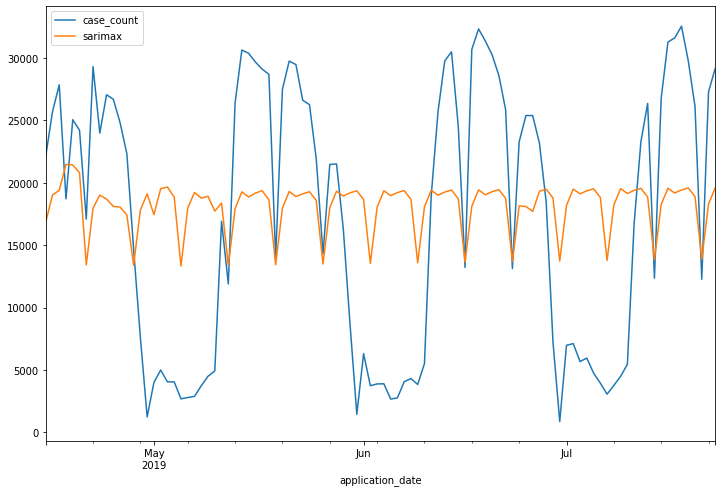

In [184]:
test_2['case_count'].plot(figsize = (12,8),legend = True)
test_2['sarimax'].plot(legend = True)


In [185]:
print('MAPE:', mean_absolute_percentage_error(test_2['case_count'],test_2['sarimax']))

MAPE: 164.92211646493408


In [186]:
# orders_3 = auto_arima(df_train_s2_ar['case_count'],exogenous=df_train_s2_ar[['holiday']],seasonal = True,m=30)

In [187]:
#orders_3.summary()

## Multiple seasonality prevails in segment 2, therefore building model using TBATS (Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components)

In [188]:
from tbats import TBATS, BATS

In [189]:
estimator = TBATS(seasonal_periods=(7, 30)) ## weekly (7) and monthly(30) seasonality

In [190]:
model = estimator.fit(train_2['case_count'])

In [191]:
test_2['tbats'] = model.forecast(len(test_2))

C:\Users\somal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


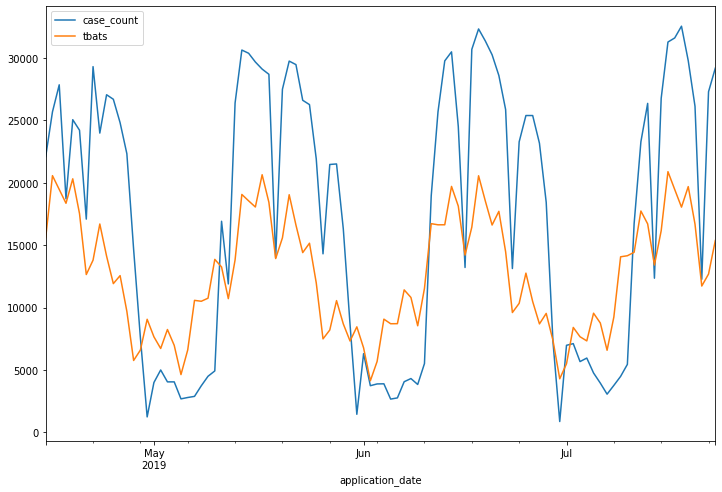

In [192]:
#train_2['case_count'].plot(figsize = (12,8),legend = True)
test_2['case_count'].plot(figsize = (12,8),legend = True)
test_2['tbats'].plot(legend = True)

In [193]:
print('MAPE:', mean_absolute_percentage_error(test_2['case_count'],test_2['tbats']))

MAPE: 73.43186224299743


## MAPE using TBATS for segment 2 is 73.43, it performed better than SARIMAX, SA,MA,SES

## using FBProphet for segment 2

In [194]:
from fbprophet import Prophet

In [195]:
df_train_s2_fb = df_train_s2_ar

In [196]:
df_train_s2_fb.drop(columns = ['hol','holiday'],inplace=True)

In [197]:
df_train_s2_fb.columns

Index(['case_count'], dtype='object')

In [198]:
df_train_s2_fb = df_train_s2_fb.reset_index()

In [199]:
df_train_s2_fb.columns = ['ds','y']

In [200]:
train_fb = df_train_s2_fb[:len(df_train_s2_fb)-100]
test_fb = df_train_s2_fb[len(df_train_s2_fb)-100:]

In [201]:
m = Prophet()


In [202]:
m.fit(train_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [203]:
future = m.make_future_dataframe(periods = len(test_fb),freq='D')

In [204]:
len(future)

844

In [205]:
len(train_fb)

744

In [206]:
test_forecast = m.predict(future)

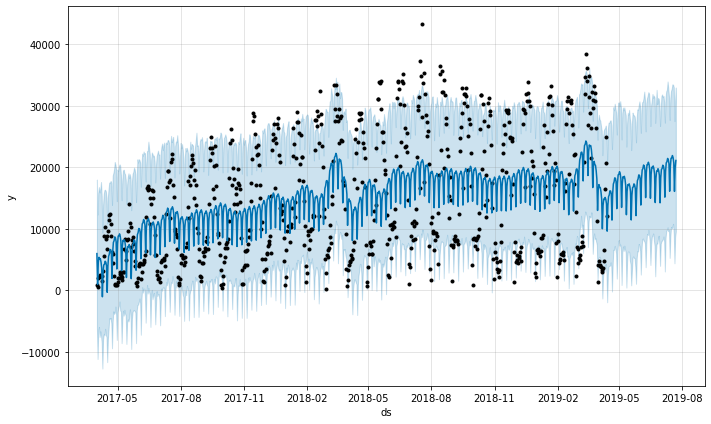

In [207]:
m.plot(test_forecast);

In [208]:
pred = test_forecast[len(test_forecast)-100:]

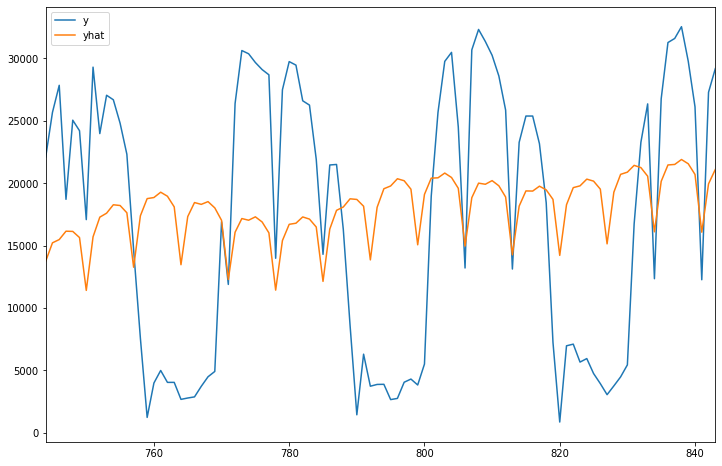

In [209]:
test_fb['y'].plot(figsize = (12,8),legend = True)
pred['yhat'].plot(figsize = (12,8),legend = True)

In [210]:
print('MAPE:', mean_absolute_percentage_error(test_fb['y'],pred['yhat']))

MAPE: 169.54001879676534


# BEST Models for segment 1

## 1. MAPE using HOLT method (double exponential smoothening,which adds trend component) is = 225.52

## 2. MAPE using FBProphet for segment is 260.83

# BEST Models for segment 2

## 1. MAPE using LGBM regression for segement 2 is 22.2

## 2. MAPE for segment 2 using XGBOOST regression is 30.62


